<a href="https://colab.research.google.com/github/younghun-cha/Healthcare-Big-Data-Engineer/blob/main/AI/03-Machine_Learning/03_Hyperparameter_Spaceship_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hyper-parameter 최적화: Spaceship Titanic

## 1. 패키지 불러오기

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic'

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import plot_confusion_matrix
from xgboost import XGBClassifier

## 2. 데이터 불러오기 & 탐색

In [ ]:
df = pd.read_csv('../dataset/spaceship-preprocessing.csv')
df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,0
1,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,1
2,1,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0
3,1,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0
4,0,0,2,16.0,0,303.0,70.0,151.0,565.0,2.0,1


In [ ]:
df.shape

(8693, 11)

In [ ]:
df['Transported'].value_counts()

1    4378
0    4315
Name: Transported, dtype: int64

In [ ]:
df.isnull().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


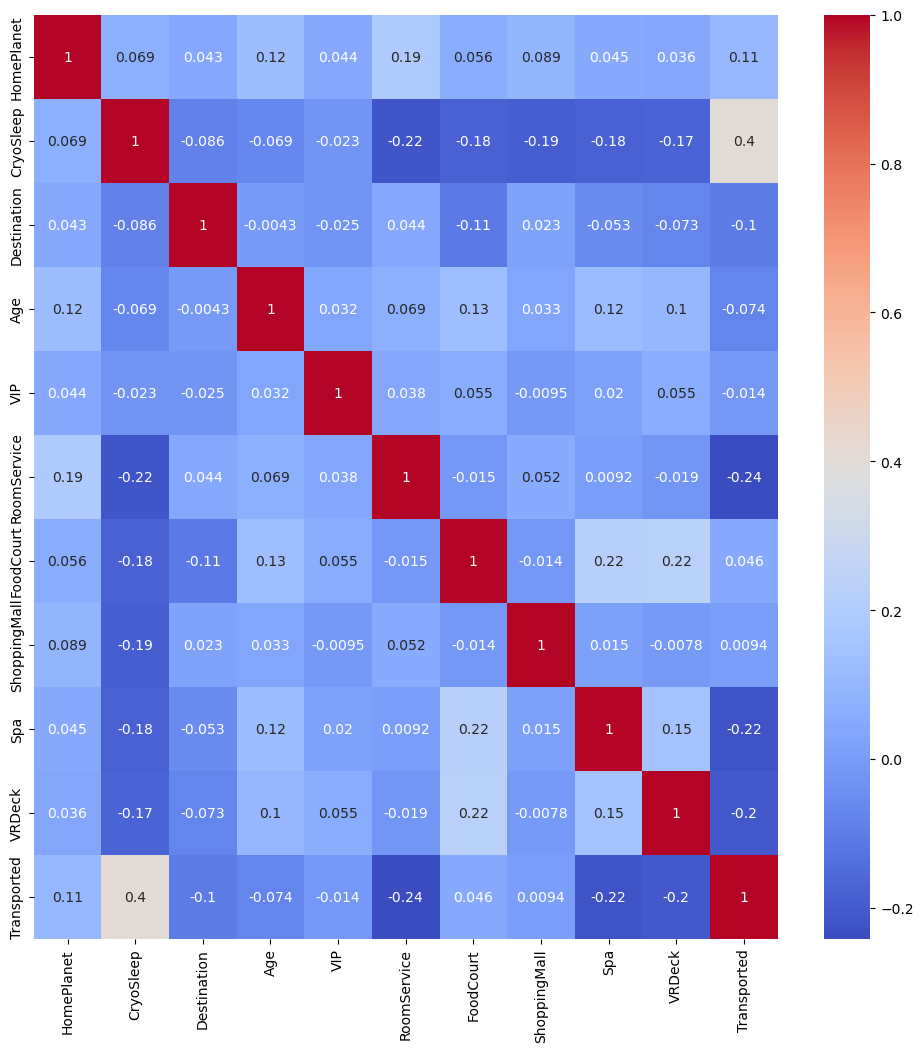

In [ ]:
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

## 2-Split the data

In [ ]:
X = df.drop('Transported' , axis =1 )
y = df['Transported']
X_train , X_test , y_train , y_test = train_test_split(X , 
                                                       y, 
                                                       random_state = 100,
                                                       test_size =0.2)

X_train.shape, X_test.shape

((6954, 10), (1739, 10))

## 3-Standardize Scale

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

def get_best_score(model):
    
    print(model.best_score_)
    print(model.best_params_)
    print(model.best_estimator_)
    
    return model.best_score_

In [ ]:
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve

def evaluate(model, y_pred):
    plot_confusion_matrix(model, X_test, y_test)
    print(classification_report(y_test, y_pred))
    plot_roc_curve(model, X_test, y_test)

## 4-Parameter tuning `GridSearchCV`

### XGBoost

https://xgboost.readthedocs.io/en/latest/parameter.html

> 주요 Hyper-parameter
- max_depth: 개별 나무의 깊이 (나무를 대충하기 위해 작은값)
- learning_rate: Boosting 단계 별로 가중치를 두는 학습율
- n_estimators: 나무의 수
- subsample: 각 나무를 학습할 때 사용하는 포인트 수의 비율 (0 초과 1 이하의 숫자로 비율 설정)
- colsample_bytree: 각 나무에서 사용하는 features 수의 비율 (0 초과 1 이하의 숫자로 비율 설정)
- gamma: 각 나무에서 분할하는데 필요한 최소 손실감소량
- reg_lambda: 각 나무에 배정되는 weights에 대하여 L2-regularization 강도

In [ ]:
param_grid = {'max_depth': [3, 10],
              'learning_rate': [0.001, 0.1],
              'n_estimators': [100, 200],
              'subsample': [0.7, 0.8],
              'reg_lambda': [0.01, 0.1],
              'colsample_bytree': [0.8, 1],
              'gamma': [0.1, 0.9]
              }

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=1234)
xgb_grid = GridSearchCV(estimator=xgb, 
                        param_grid=param_grid, 
                        cv=3, 
                        verbose=2, 
                        n_jobs=-1)

xgb_grid.fit(X_train, y_train)
get_best_score(xgb_grid);

Fitting 3 folds for each of 128 candidates, totalling 384 fits
0.7959447799827437
{'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.001, 'max_depth': 10, 'n_estimators': 200, 'reg_lambda': 0.1, 'subsample': 0.7}
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1234, ...)


              precision    recall  f1-score   support

           0       0.83      0.77      0.80       885
           1       0.78      0.83      0.80       854

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



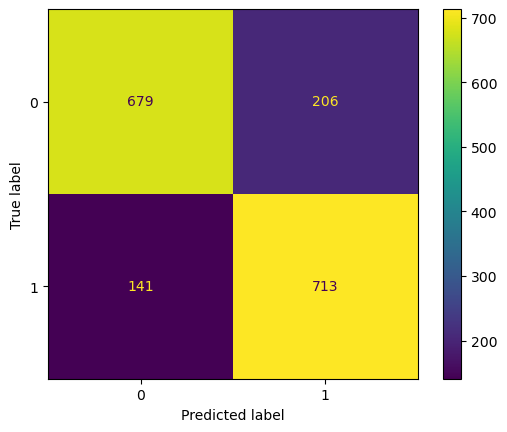

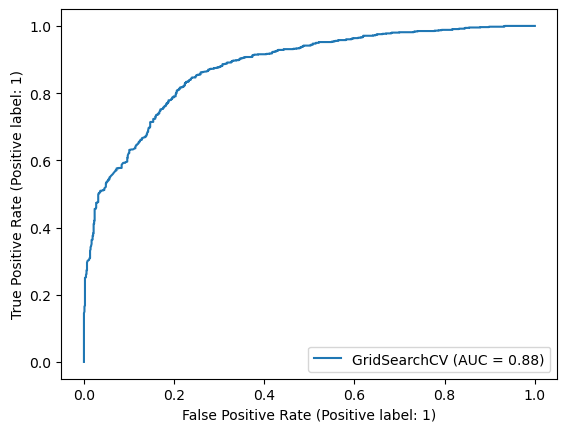

In [ ]:
y_pred_grid = xgb_grid.predict(X_test)
evaluate(xgb_grid, y_pred_grid)

## 5-Parameter tuning `RandomSearchCV`

In [ ]:
xgb = XGBClassifier(random_state=1234)
xgb_rand = RandomizedSearchCV(xgb, 
                        param_grid, 
                        cv=5, 
                        verbose=2, 
                        n_jobs=-1)

xgb_rand.fit(X_train, y_train)
get_best_score(xgb_rand);

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.7943639739538348
{'subsample': 0.8, 'reg_lambda': 0.1, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.001, 'gamma': 0.1, 'colsample_bytree': 1}
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.1, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1234, ...)


              precision    recall  f1-score   support

           0       0.81      0.77      0.79       885
           1       0.78      0.82      0.80       854

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.80      0.79      0.79      1739



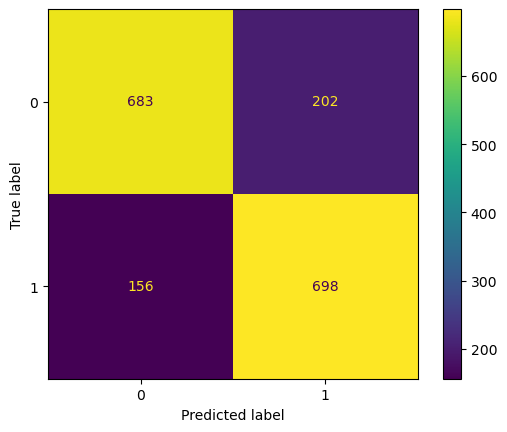

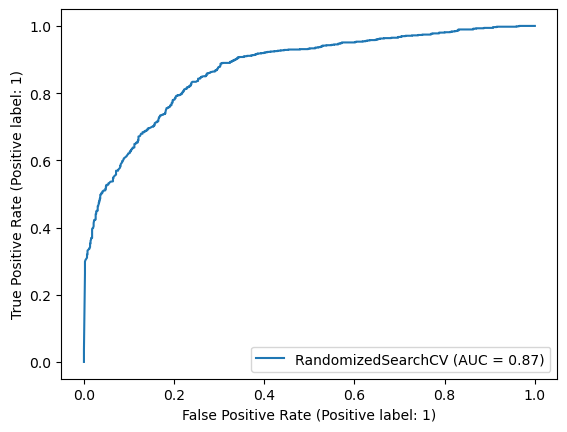

In [ ]:
y_pred_rand = xgb_rand.predict(X_test)
evaluate(xgb_rand, y_pred_rand)

## 6-Parameter tuning `BayesianOptimization`
- https://github.com/fmfn/BayesianOptimization

In [ ]:
%pip install bayesian-optimization

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from bayes_opt import BayesianOptimization

In [ ]:
def xgb_cv(max_depth, 
           learning_rate, 
           n_estimators, 
           subsample, 
           reg_lambda,
           colsample_bytree,
           gamma
          ):
    
    xgb = XGBClassifier(n_jobs=-1,
                        max_depth=int(max_depth),
                        learning_rate=learning_rate,
                        n_estimators=int(n_estimators),
                        subsample=subsample,
                        reg_lambda=reg_lambda,
                        random_state=1234,
                        colsample_bytree=colsample_bytree,
                        gamma=gamma
                       )
    
    return cross_val_score(xgb, 
                           X_train, 
                           y_train, 
                           scoring='accuracy', cv=5).mean()

In [ ]:
xgb_opt = BayesianOptimization(xgb_cv,
                                 {'max_depth': [3, 10],
                                  'learning_rate': [0.001, 0.1],
                                  'n_estimators': [100, 200],
                                  'subsample': [0.7, 0.8],
                                  'reg_lambda': [0.01, 0.1],
                                  'colsample_bytree': [0.8, 1],
                                  'gamma': [0.1, 0.9]
                                  }, random_state=1234)

In [ ]:
xgb_opt.maximize(init_points=2, n_iter=5)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.7928    | 0.8383    | 0.5977    | 0.04434   | 8.498     | 178.0     | 0.03453   | 0.7276    |
| 2         | 0.7921    | 0.9604    | 0.8665    | 0.08772   | 5.505     | 150.1     | 0.07151   | 0.7713    |
| 3         | 0.7922    | 0.9507    | 0.2435    | 0.05679   | 7.534     | 177.2     | 0.08612   | 0.783     |
| 4         | 0.789     | 0.9374    | 0.811     | 0.0895    | 3.119     | 150.7     | 0.09505   | 0.7451    |
| 5         | 0.7807    | 1.0       | 0.1       | 0.1       | 9.801     | 177.0     | 0.1       | 0.7       |
| 6         | 0.7875    | 0.9343    | 0.7444    | 0.08127   | 8.313     | 177.4     | 0.08514   | 0.794     |
| 7         | 0.7913    | 0.9546    | 0.2966    | 0.08374   | 5.294     | 105.1     | 0.01197   | 0.7854    |


In [ ]:
xgb_opt.max

{'target': 0.7927810332610978,
 'params': {'colsample_bytree': 0.8383038900757784,
  'gamma': 0.5976870168318655,
  'learning_rate': 0.04433504616170433,
  'max_depth': 8.497510085996385,
  'n_estimators': 177.99758081188037,
  'reg_lambda': 0.03453333447543775,
  'subsample': 0.7276464255143097}}

In [ ]:
best_params = xgb_opt.max['params']
best_params

{'colsample_bytree': 0.8383038900757784,
 'gamma': 0.5976870168318655,
 'learning_rate': 0.04433504616170433,
 'max_depth': 8.497510085996385,
 'n_estimators': 177.99758081188037,
 'reg_lambda': 0.03453333447543775,
 'subsample': 0.7276464255143097}

In [ ]:
best_params['max_depth']

8.497510085996385

In [ ]:
xgb_bayes = XGBClassifier(max_depth=int(best_params['max_depth']),
                          learning_rate=best_params['learning_rate'],
                          n_estimators=int(best_params['n_estimators']),
                          reg_lambda=best_params['reg_lambda'],
                          subsample=best_params['subsample'])

In [ ]:
xgb_bayes.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04433504616170433,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=177, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

              precision    recall  f1-score   support

           0       0.81      0.76      0.78       885
           1       0.76      0.82      0.79       854

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



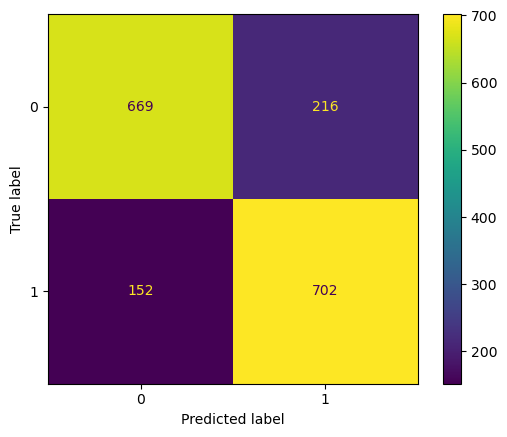

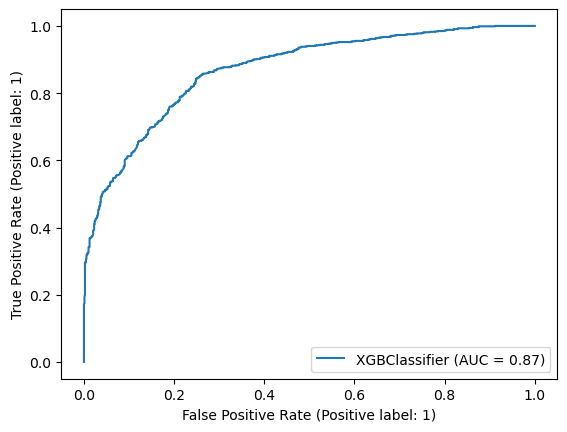

In [ ]:
y_pred_bayes = xgb_bayes.predict(X_test)
evaluate(xgb_bayes, y_pred_bayes)